**BUTTERFLY CLASSIFICATION WITH CNN**

First, let's import the libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

2025-09-25 17:13:16.657161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758820396.890624      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758820396.960073      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let's import our data and check its dimensions.

In [2]:
data = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
data.shape

(6499, 2)

In [3]:
test_data = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
test_data.shape

(2786, 1)

Our train data consists of 6499 rows and 2 columns, and our test data consists of 2786 rows and 1 column.

Then let's look at the first 10 rows of data

In [4]:
data.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


Let's see how many pictures there are of each butterfly species.

In [5]:
data['label'].value_counts()

label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
SCARCE SWALLOW     97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

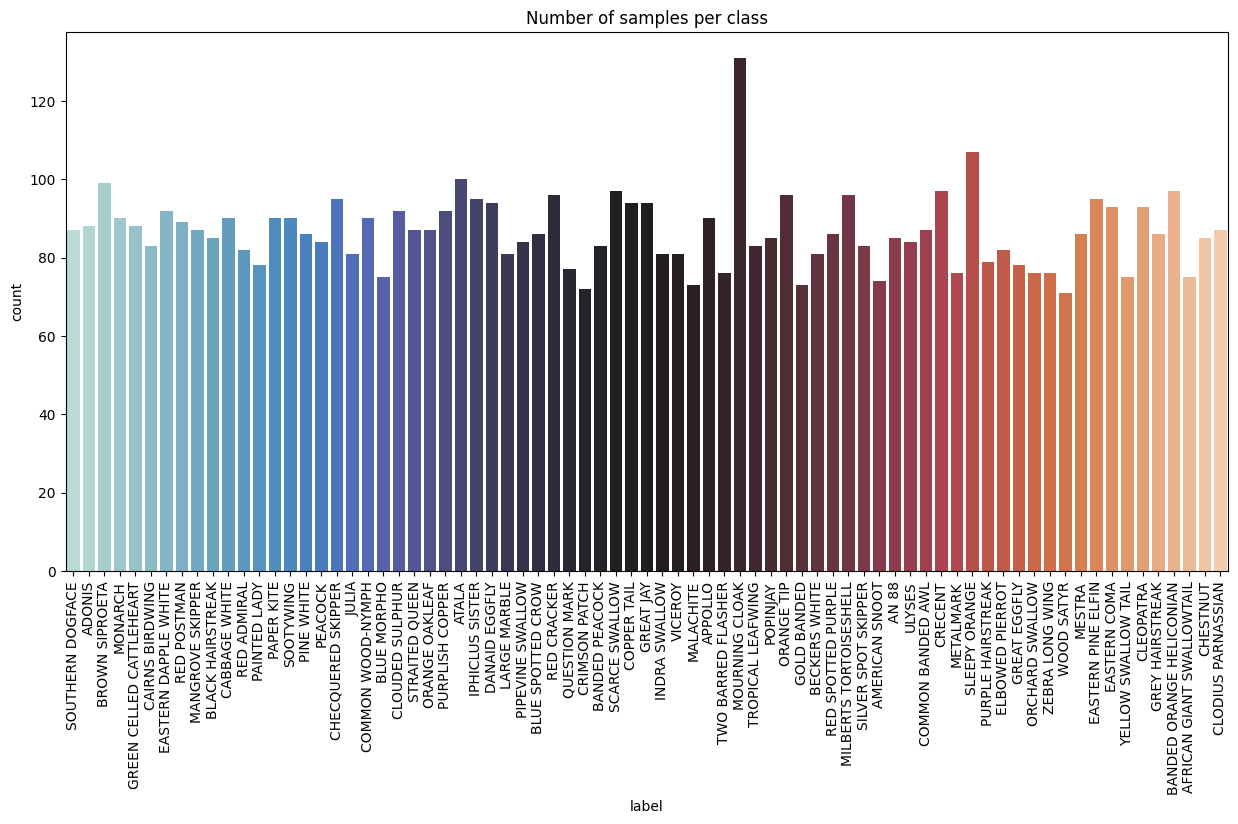

In [6]:
plt.figure(figsize=(15,7))

sns.countplot(x="label", data=data, palette="icefire")

plt.title("Number of samples per class")
plt.xticks(rotation=90)  
plt.show()

We charted the numbers of butterfly species.

Let's visualize 8 randomly selected data from the data set and see what our photos look like.

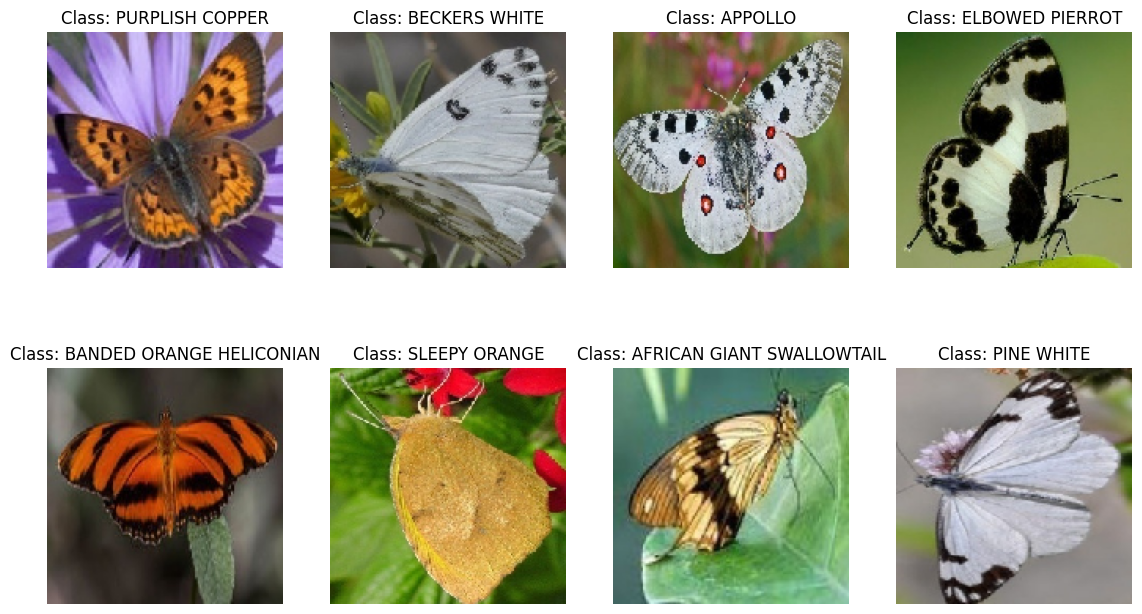

In [7]:
image_dir = '/kaggle/input/butterfly-image-classification/train'

fig4, axes = plt.subplots(2,4, figsize=(14,8))

sample_images = data.sample(8, random_state=10)

for i, (index, row) in enumerate(sample_images.iterrows()):
    image_path = os.path.join(image_dir, row['filename'])
    image = load_img(image_path, target_size=(150,150))
    image_array = img_to_array(image) / 255
    ax = axes[i // 4, i %4]
    
    ax.imshow(image_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')
    
plt.show()

Now that the data exploration is complete, we can start preprocessing.

Split the dataset into training (80%) and validation (20%) sets using train_test_split.

Define an ImageDataGenerator for training with:

* Rescaling pixel values to [0, 1]
* Data augmentation: rotation, width/height shift, shear, zoom, horizontal flip

Define an ImageDataGenerator for validation with only rescaling.

Use flow_from_dataframe to:

* Load images from the specified directory
* Match filenames with labels from the dataframe
* Resize images to 150×150 pixels
* Organize images into batches of 32
* Prepare data for categorical classification

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

image_dir = '/kaggle/input/butterfly-image-classification/train'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


And create our model:

* Define Optimizers

First, a list of different optimizers with various learning rates is created. In this case, Adam with two learning rates (0.001, 0.01), SGD with momentum, and RMSprop are included.

* Loop Through Optimizers


A loop iterates over each optimizer in the list. For each iteration:

A new CNN model is defined using Sequential. The architecture includes convolutional layers, max pooling, a flatten layer, and dense layers with ReLU and softmax activations.

The model is compiled with the current optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.

The model is trained using model.fit() on the train_generator with validation on val_generator for 15 epochs.

* Store Accuracy Results

After training, the final epoch’s training and validation accuracy are extracted from history.history and stored in the results dictionary using a key that identifies the optimizer and learning rate.


In [9]:
optimizers = [
    Adam(learning_rate=0.001),
    Adam(learning_rate=0.01),
    SGD(learning_rate=0.01, momentum=0.9),
    RMSprop(learning_rate=0.01)
]

results = {}
loss_histories = {} 

for opt in optimizers:
    
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(75, activation='softmax')
    ])
    
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=35,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    
    train_acc = history.history["accuracy"][-1]
    val_acc = history.history["val_accuracy"][-1]

    loss_histories[f"{opt.__class__.__name__}_lr{opt.learning_rate.numpy()}"] = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"]
    }
    
    results[f"{opt.__class__.__name__}_lr{opt.learning_rate.numpy()}"] = {
        "train_acc": train_acc,
        "val_acc": val_acc
    }

I0000 00:00:1758820419.388133      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758820419.388806      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/35


I0000 00:00:1758820423.821184      65 service.cc:148] XLA service 0x7ed5580059a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758820423.822109      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758820423.822127      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758820424.134952      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/162 ━━━━━━━━━━━━━━━━━━━━ 16:54 6s/step - accuracy: 0.0000e+00 - loss: 4.3193

I0000 00:00:1758820427.663890      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.0345 - loss: 4.1537 - val_accuracy: 0.1672 - val_loss: 3.6189
Epoch 2/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1250 - loss: 3.3841 - val_accuracy: 0.1766 - val_loss: 3.4575
Epoch 3/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.2059 - loss: 3.0726 - val_accuracy: 0.3031 - val_loss: 2.5564
Epoch 4/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1562 - loss: 3.0938 - val_accuracy: 0.3180 - val_loss: 2.5048
Epoch 5/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.3264 - loss: 2.5030 - val_accuracy: 0.4195 - val_loss: 2.0662
Epoch 6/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2812 - loss: 2.6192 - val_accuracy: 0.4187 - val_loss: 2.0832
Epoch 7/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.4266 - loss: 2.0915 - val_accuracy: 0.5031 - val_loss: 1.7224
Epoch 8/35
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5625 - loss: 1.6417 - val_accurac

In [10]:
for k, v in results.items():
    print(f"{k}: train_acc={v['train_acc']:.4f}, val_acc={v['val_acc']:.4f}")

Adam_lr0.0010000000474974513: train_acc=0.7662, val_acc=0.7109
Adam_lr0.009999999776482582: train_acc=0.0184, val_acc=0.0266
SGD_lr0.009999999776482582: train_acc=0.6739, val_acc=0.6625
RMSprop_lr0.009999999776482582: train_acc=0.0180, val_acc=0.0273


The results show that Adam with a learning rate of 0.001 achieved the best performance, reaching 72.67% training and 70.08% validation accuracy. In contrast, Adam with a higher learning rate (0.01) completely failed to learn, suggesting divergence. SGD with 0.01 performed reasonably well, achieving 67.37% training and 64.61% validation accuracy, while RMSprop with 0.01 showed weak learning, with much lower accuracies. Overall, Adam at 0.001 proved to be the most effective choice.

The plot lets you compare how different optimizers affect training and validation accuracy over time.

* Solid lines show the training accuracy for each optimizer.

* Dashed lines show the validation accuracy for each optimizer.

* X-axis represents the epochs, and Y-axis represents accuracy.

* The legend tells you which line belongs to which optimizer and dataset (train or validation).

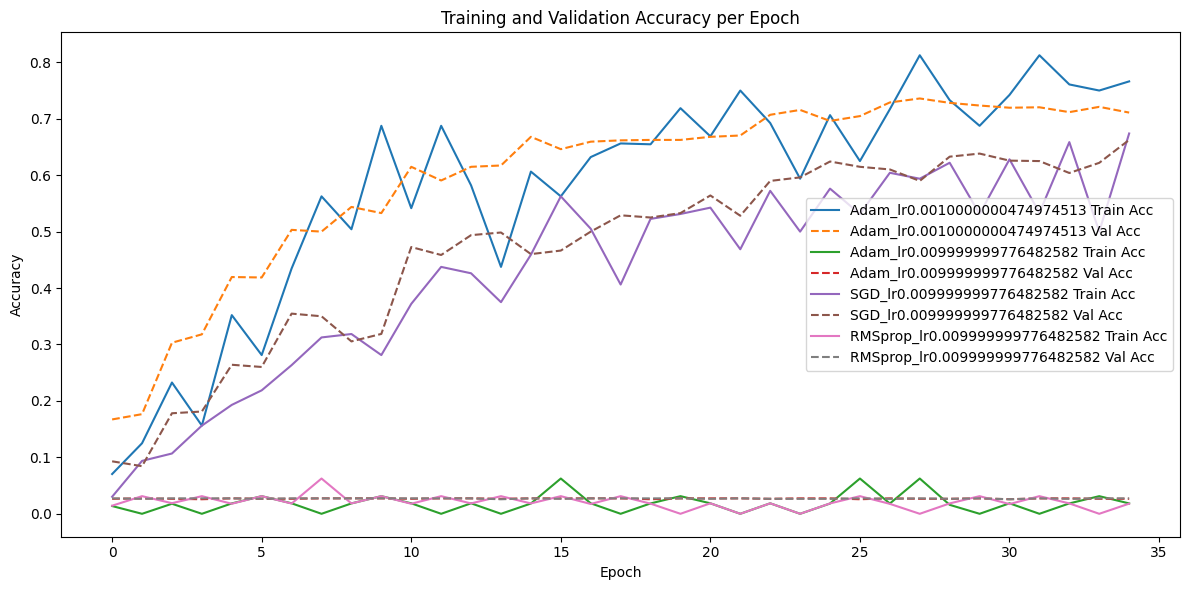

In [11]:
plt.figure(figsize=(12,6))
for key, history_data in loss_histories.items():
    plt.plot(history_data["accuracy"], label=f"{key} Train Acc")
    plt.plot(history_data["val_accuracy"], linestyle="--", label=f"{key} Val Acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

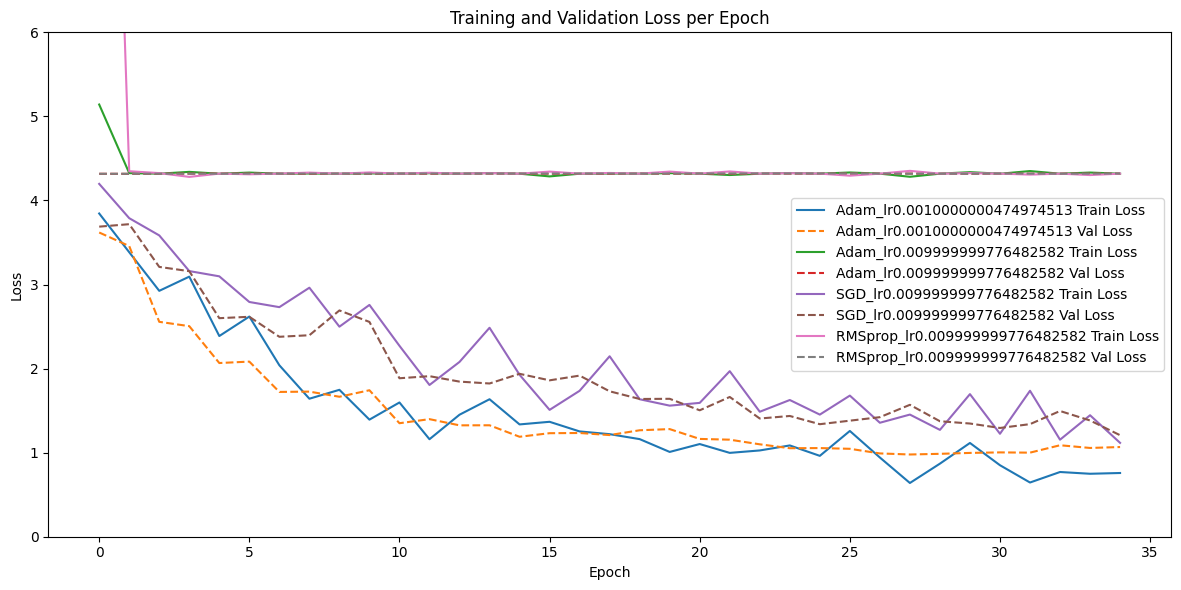

In [12]:
plt.figure(figsize=(12,6))
for key, history_data in loss_histories.items():
    plt.plot(history_data["loss"], label=f"{key} Train Loss")
    plt.plot(history_data["val_loss"], linestyle="--", label=f"{key} Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.ylim(0, max(max(history_data["loss"]), max(history_data["val_loss"])) * 1.1)  # Dinamik ölçek
plt.tight_layout()
plt.ylim(0, 6)
plt.show()

Let's use the optimal optimizer, Adam(lr=0.001), to create the confusion matrix.

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.0331 - loss: 4.2688 - val_accuracy: 0.1346 - val_loss: 3.4404
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2188 - loss: 3.4415 - val_accuracy: 0.1408 - val_loss: 3.4940
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.1793 - loss: 3.1631 - val_accuracy: 0.3146 - val_loss: 2.4571
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2812 - loss: 2.6889 - val_accuracy: 0.3238 - val_loss: 2.4359
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.2992 - loss: 2.5673 - val_accuracy: 0.3985 - val_loss: 2.1884
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2812 - loss: 2.4922 - val_accuracy: 0.4162 - val_loss: 2.0906
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.3975 - loss: 2.1389 - val_accuracy: 0.4677 - val_loss: 1.8248
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3125 - loss: 2.3116 - 

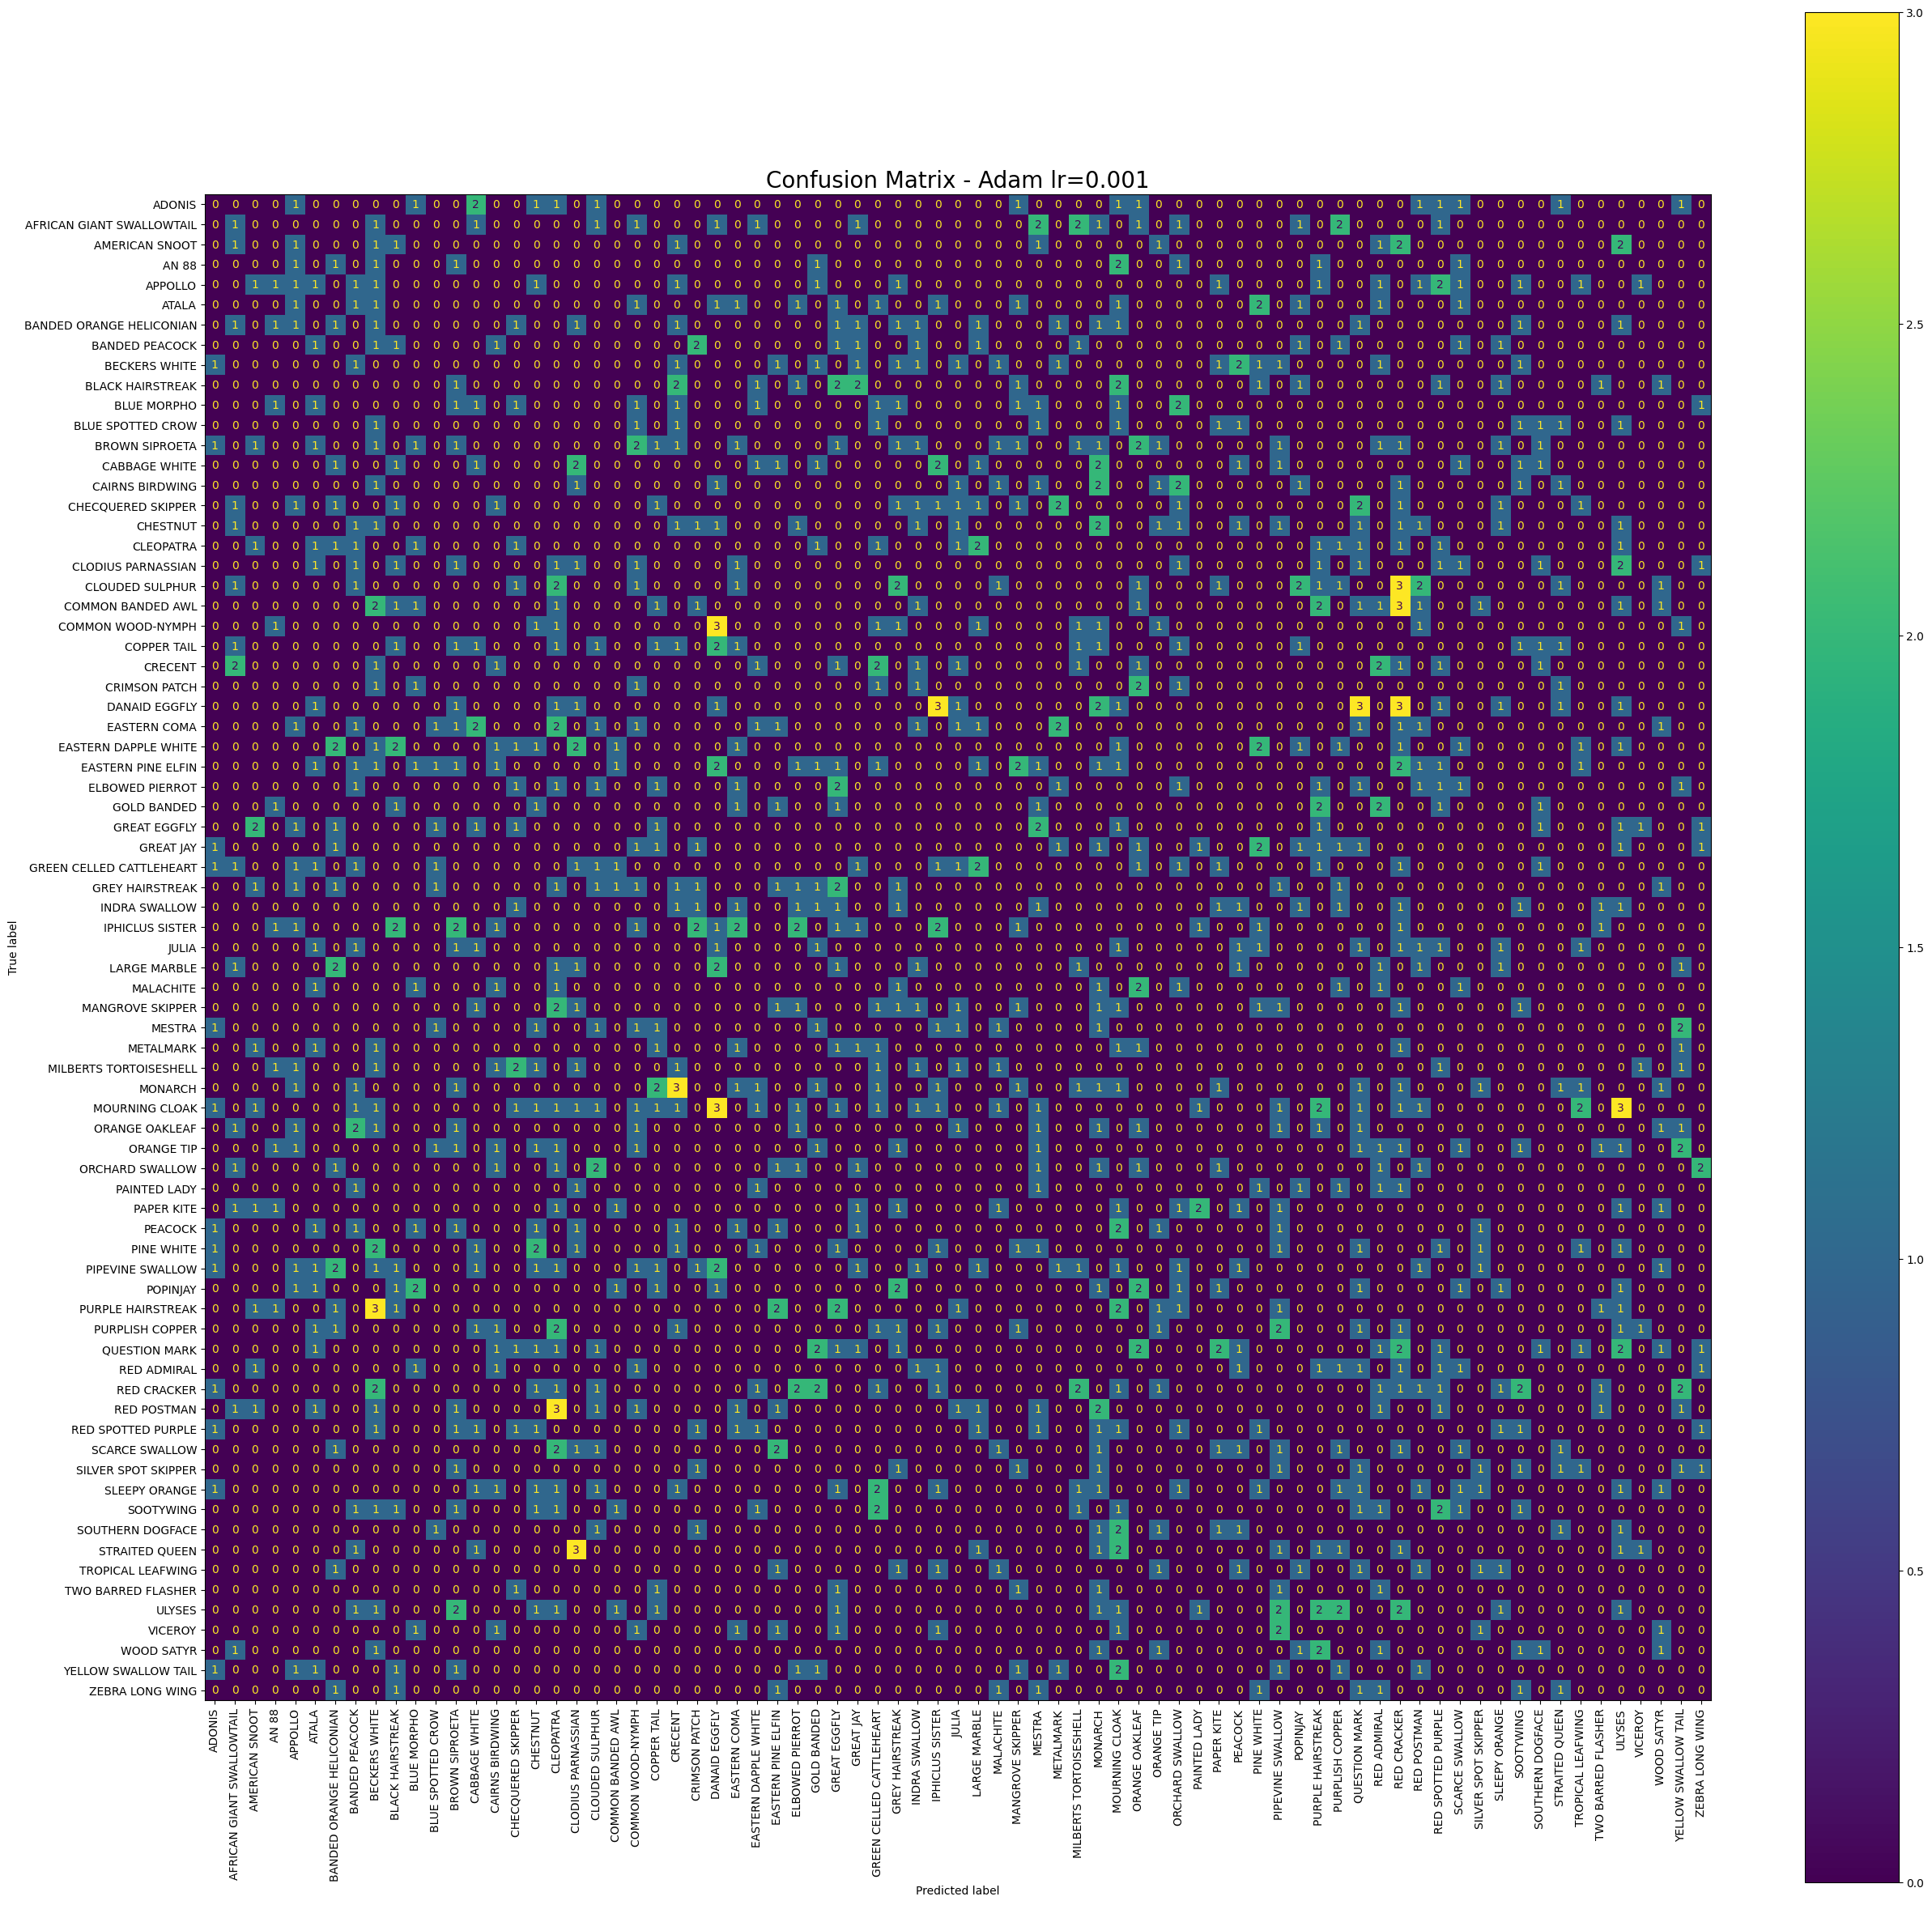

In [13]:
opt = Adam(learning_rate=0.001)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size)
)

val_generator.reset()
steps = math.ceil(val_generator.samples / val_generator.batch_size)
y_pred_probs = model.predict(val_generator, steps=steps)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = val_data['label'].map(lambda x: train_generator.class_indices[x]).to_numpy()

labels = [k for k,_ in sorted(train_generator.class_indices.items(), key=lambda x:x[1])]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30,30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=plt.gca(), xticks_rotation=90, colorbar=True)
plt.title("Confusion Matrix - Adam lr=0.001", fontsize=20)
plt.show()


The model was trained using the Adam optimizer with a learning rate of 0.001 for 50 epochs, achieving an accuracy of 90.62%. According to the confusion matrix, the number of misclassifications per class ranged from 0 to 3, showing that the errors were minimal and evenly distributed across classes.